# Dope RNN training with BPTT

Train the RNN weights directly using standard BPTT for a flip-flop task w/ delayed loss evaluation.
(Should only work for short delays due to vanishing gradient problem.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from disp import set_plot, colors

print('Torch version:', torch.__version__)
print('Cuda available:', torch.cuda.is_available())

device = 'cuda' if  torch.cuda.is_available() else 'cpu'
print('Device:', device)  # tested on cpu and cuda

Torch version: 1.12.1
Cuda available: False
Device: cpu


In [2]:
torch.manual_seed(1337)

# model params
D = 2
N = 2000
TAU = .01
G = 100
DT = .001

J_psi = G*torch.randn((N, D), device=device)
B = torch.eye(D, device=device)
C = torch.eye(D, device=device)

def get_z(x):
    return 1*x

def psi_fn(z):
    return (1+torch.tanh(J_psi@z))*np.sqrt(2/N)

def advance(x, z, w_T, u):
    psi = psi_fn(z).reshape((N, 1))
    x_next = x + DT/TAU*(-x + C@w_T@psi + B@u)
    return x_next

In [3]:
# smln params
T = 1.1

LR = .01
NEPOCH = 400

# initial conditions
x_0 = torch.tensor([[1., 1]], device=device).T
w_T_hat_0 = torch.zeros((D, N), device=device)

# inputs
T_U_STIMS = [DT, T/2+DT]

# loss eval
# DELAY = .06
DELAY = .5  # should fail due to VGP
T_LOSSS = [T_U_STIM + DELAY for T_U_STIM in T_U_STIMS]

In [4]:
IT = int(round(T/DT))
t = np.arange(IT)*DT

IT_U_STIMS = [int(round(T_U/DT)) for T_U in T_U_STIMS]
IT_LOSSS = [int(round(T_LOSS/DT)) for T_LOSS in T_LOSSS]

# make inputs
us = torch.zeros((IT, D), device=device)
us[:, 1] = 1.
us[IT_U_STIMS[0], 0] = -.02/DT
us[IT_U_STIMS[1], 0] = .02/DT

In [5]:
# specify loss
MLOSS = torch.zeros((IT, D), device=device)  # mask for loss
MLOSS[IT_LOSSS, 0] = 1

TARGS = torch.zeros((IT, D), device=device)
TARGS[MLOSS > 0] = torch.tensor([-1., 1.], device=device)

def loss_fn(zs):
    return torch.mean(((zs - TARGS)**2)[MLOSS>0])

In [6]:
w_T_hat = w_T_hat_0.clone().detach()
w_T_hat.requires_grad = True

losses = []
w_T_hats_save = []
z_hats_save = []

for epoch in range(NEPOCH):

    x_hats = [x_0.clone()]
    z_hats = [get_z(x_hats[0])]

    for ct in range(1, IT):
        x_hat_next = advance(x_hats[-1], z_hats[-1], w_T_hat, us[[ct], :].T)
        z_hat_next = get_z(x_hat_next)

        x_hats.append(x_hat_next)
        z_hats.append(z_hat_next)

    x_hats_cc = torch.cat(x_hats, dim=1).T
    z_hats_cc = torch.cat(z_hats, dim=1).T

    loss = loss_fn(z_hats_cc)
    loss.backward()

    with torch.no_grad():
        w_T_hat -= LR*w_T_hat.grad
        w_T_hat.grad.zero_()

    losses.append(loss.item())

    if epoch == 0 or ((epoch + 1)%50 == 0) or (epoch+1 == NEPOCH):
        z_hats_save.append(z_hats_cc.clone().detach().numpy())
        w_T_hats_save.append(w_T_hat.clone().detach().numpy())

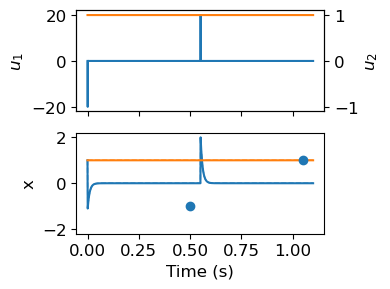

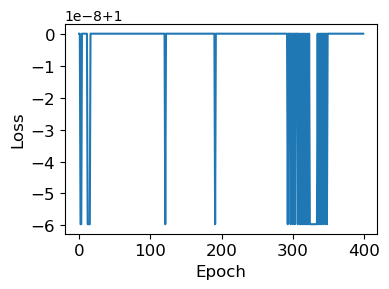

In [18]:
fig, axs = plt.subplots(2, 1, figsize=(4, 3), tight_layout=True, sharex=True)

axs[0].plot(t, us[:, 0])
set_plot(axs[0], y_label=r'$u_1$')

ax_0_twin = axs[0].twinx()
ax_0_twin.plot(t, us[:, 1], c=colors[1], zorder=2)
set_plot(ax_0_twin, y_lim=(-1.1, 1.1), y_label=r'$u_2$')

for d, c in zip(range(D), colors):
    axs[1].plot(t, z_hats_save[0][:, d], c=c, lw=1, ls='--', zorder=0)
    axs[1].plot(t, z_hats_save[-1][:, d], c=c, zorder=1)
    
for itmloss, cmloss in torch.nonzero(MLOSS):
    axs[1].scatter(itmloss*DT, TARGS[itmloss, cmloss], c=colors[0], zorder=2)
    
set_plot(axs[1], y_lim=(-2.2, 2.2), x_label='Time (s)', y_label='x')

fig.savefig(f'ms/5_bptt_hold_task_delay_{DELAY}.svg')

fig, ax = plt.subplots(1, 1, figsize=(4, 3), tight_layout=True)
ax.plot(range(NEPOCH), losses)
set_plot(ax, x_label='Epoch', y_label='Loss')